In [1]:
from Agents import FCFFwdUnsupAgent
from SupModules import FCFFwdSupModule
from MetaOptimizationMethods import GeneticMethodB
import torch
from SemiSupMethods import SemiSupMethod1
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
from time import time as tm
import warnings
import matplotlib.cm as colormap
import seaborn as sns
import matplotlib.colors


# Number of unsupervised and supervised
# iterations for semi-sup  learning
NumItUnsup = 10
NumItSup = 50

# Batch sizes
unsup_batch_size = 128
train_batch_size = 128
test_batch_size = 128

# Number of generations
NumGenerations=20

# Population size
PopSize=60

# Standard deviation for initializing
# meta-params
InitialMetaParamStd = .01

# Evolutionary hyperparams
Temperature=InitialMetaParamStd
NumParents=(int)(PopSize/3)
lam = 0


# Hyperparams for unsup agents
UnsupHyperParams = {}
UnsupHyperParams["Depth"]=5
UnsupHyperParams["InWidth"]= 28 * 28
UnsupHyperParams["HiddenWidth"]=100
UnsupHyperParams["OutWidth"]=100
UnsupHyperParams["gHidden"]=torch.tanh#nn.ReLU()
UnsupHyperParams["gLast"]=torch.tanh#nn.ReLU()

# Hyperparams for sup module
SupHyperParams = {}
SupHyperParams["Depth"]=3
SupHyperParams["InWidth"]= UnsupHyperParams["OutWidth"]
SupHyperParams["HiddenWidth"]=50
SupHyperParams["OutWidth"]=10
SupHyperParams["gHidden"]=nn.ReLU()
SupHyperParams["gLast"]=nn.Identity()

# Function to get an initialized supervised learning module
def SupModuleGetter():
    return FCFFwdSupModule(SupHyperParams)

# Import and build data loaders
from torchvision.datasets import MNIST
train_dataset = MNIST('./',
      train=True,
      transform=transforms.ToTensor(),
      download=True)
test_dataset = MNIST('./',
      train=False,
      transform=transforms.ToTensor(),
      download=True)
unsup_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=unsup_batch_size,
                                          shuffle=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=True)


# iInitialize meta-parameters
NumMetaParams = 8
MetaParams=torch.zeros(NumGenerations,PopSize,NumMetaParams)
MetaParams[0,:,:]= InitialMetaParamStd * torch.randn(PopSize, NumMetaParams)

# Supervised loss function and optimizer
SupLossFun = nn.CrossEntropyLoss()
SupOptimizerGetter = torch.optim.Adam

# Semi-supervised learning method
method1 = SemiSupMethod1(SupModuleGetter, SupLossFun, SupOptimizerGetter, NumItUnsup, NumItSup)

# Create a population of unsupervised learning agents
Population=[FCFFwdUnsupAgent(MetaParams[0,j,:], UnsupHyperParams) for j in range(PopSize)]

# Ignore warning messages
# Initialize other stuff
t0=tm()
MetaLoss=torch.zeros(NumGenerations,PopSize)
MeanLossCurves=torch.zeros(NumGenerations,NumItSup)
MeanAccuracyCurves=torch.zeros(NumGenerations,NumItSup)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # For each generation
    for i in range(NumGenerations):
        # Store meta-params for this generation
        MetaParams[i, :, :] = torch.stack([p.MetaParams for p in Population])

        # Perform unsupervised learning on population
        method1.UnsupLifetime(Population, unsup_loader)

        # Perform supervised learning from population to comptue meta-loss
        MetaLoss[i, :] = method1.ComputeMetaLoss(Population, train_loader, test_loader)

        # Store population-averaged training loss and accuracy curves
        MeanLossCurves[i, :] = method1.TrainLossCurve
        MeanAccuracyCurves[i, :] = method1.TrainAccuracyCurve

        GeneticMethodB(Population, MetaLoss[i,:], Temperature, NumParents, MinWeight=.5, lam=0)
        
        t1=tm()
        print('Generation',i,'of',NumGenerations,'Metaloss:',MetaLoss[i,:].mean().item(),'runtime:',t1-t0,'s')




print('done')



Generation 0 of 20 Metaloss: 0.640625 runtime: 26.449729204177856 s
Generation 1 of 20 Metaloss: 0.672656238079071 runtime: 52.07993292808533 s
Generation 2 of 20 Metaloss: 0.684374988079071 runtime: 79.55697107315063 s
Generation 3 of 20 Metaloss: 0.7274739742279053 runtime: 108.02341413497925 s
Generation 4 of 20 Metaloss: 0.7388020753860474 runtime: 137.0838770866394 s
Generation 5 of 20 Metaloss: 0.760546863079071 runtime: 165.98435997962952 s
Generation 6 of 20 Metaloss: 0.7621093988418579 runtime: 194.61677193641663 s
Generation 7 of 20 Metaloss: 0.7601562738418579 runtime: 223.82364082336426 s
Generation 8 of 20 Metaloss: 0.747265636920929 runtime: 252.61890316009521 s
Generation 9 of 20 Metaloss: 0.745312511920929 runtime: 279.87971210479736 s
Generation 10 of 20 Metaloss: 0.794140636920929 runtime: 305.8980700969696 s
Generation 11 of 20 Metaloss: 0.7783854007720947 runtime: 331.7419321537018 s
Generation 12 of 20 Metaloss: 0.819140613079071 runtime: 358.00990295410156 s
Gener

KeyboardInterrupt: 

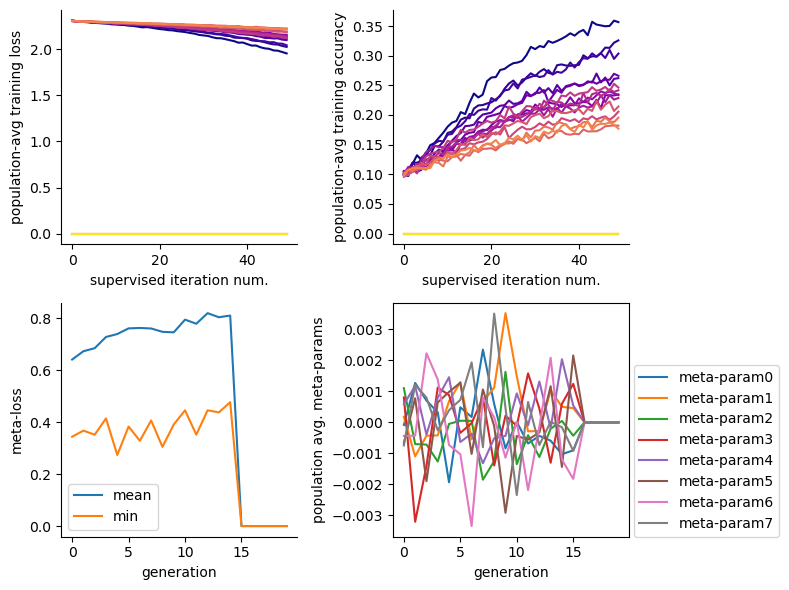

In [2]:

# choose a colormap
cm=colormap.plasma
plt.figure(figsize=(8,6))

# Plot training loss curves at all generations
# averaged over population
plt.subplot(2,2,1)
for i in range(NumGenerations):
  plt.plot(MeanLossCurves[i,:].numpy(),color=cm(i/NumGenerations),label=i)
#plt.legend(loc=[1,0])
#plt.colorbar(colormap.ScalarMappable(cmap=cm),label='generation/NumGenerations')
plt.xlabel('supervised iteration num.')
plt.ylabel('population-avg training loss')
sns.despine()

# Plot training accuracy curves at all generations
# averaged over population
plt.subplot(2,2,2)
for i in range(NumGenerations):
  plt.plot(MeanAccuracyCurves[i,:].numpy(),color=cm(i/NumGenerations),label=i)
#plt.colorbar(colormap.ScalarMappable(cmap=cm),label='generation/NumGenerations')
plt.xlabel('supervised iteration num.')
plt.ylabel('population-avg training accuracy')
sns.despine()

# Plot mean and min meta-losses across generations
plt.subplot(2,2,3)
plt.plot(MetaLoss.numpy().mean(axis=1),label='mean')
plt.plot(MetaLoss.numpy().min(axis=1),label='min')
plt.xlabel('generation')
plt.ylabel('meta-loss')
plt.legend()
sns.despine()

# Plot Mean and Best meta-params across generations
plt.subplot(2,2,4)
for jj in range(NumMetaParams):
  plt.plot(MetaParams[:,:,jj].numpy().mean(axis=1),label='meta-param'+str(jj))
plt.legend(loc=(1.02,0))
plt.xlabel('generation')
plt.ylabel('population avg. meta-params')


plt.tight_layout()



In [ ]:
MetaParams[:,0,0]